## Dane

In [1]:
import pandas as pd

smile = pd.read_excel('ImpVol.xlsx', index_col='Tenor')
smile[['ATM', '25RR', '10RR', '25BF', '10BF']] /= 100
smile['10P'] = smile['ATM'] - smile['10RR'] / 2 + smile['10BF']
smile['25P'] = smile['ATM'] - smile['25RR'] / 2 + smile['25BF']
smile['10C'] = smile['ATM'] + smile['10RR'] / 2 + smile['10BF']
smile['25C'] = smile['ATM'] + smile['25RR'] / 2 + smile['25BF']

smile

,Date,Days,ATM,25RR,10RR,25BF,10BF,10P,25P,10C,25C
Tenor,,,,,,,,,,,
ON,2024-03-06,1,0.0403,0.0038,0.0075,0.0012,0.0044,0.04095,0.03960,0.04845,0.04340
1W,2024-03-12,7,0.0452,0.0034,0.0068,0.0013,0.0049,0.04670,0.04480,0.05350,0.04820
2W,2024-03-19,14,0.0479,0.0052,0.0102,0.0015,0.0054,0.04820,0.04680,0.05840,0.05200
1M,2024-04-04,30,0.0497,0.0065,0.0126,0.0015,0.0057,0.04910,0.04795,0.06170,0.05445
2M,2024-05-02,58,0.0526,0.0087,0.0164,0.0017,0.0064,0.05080,0.04995,0.06720,0.05865
3M,2024-06-05,92,0.0534,0.0093,0.0178,0.0021,0.0071,0.05160,0.05085,0.06940,0.06015
6M,2024-09-05,184,0.0567,0.0124,0.0234,0.0027,0.0081,0.05310,0.05320,0.07650,0.06560
9M,2024-12-05,275,0.0589,0.0131,0.0244,0.0033,0.0096,0.05630,0.05565,0.08070,0.06875
1Y,2025-03-05,365,0.0595,0.0135,0.0255,0.0035,0.0098,0.05655,0.05625,0.08205,0.06975


In [2]:
vols = smile.loc['3M'][['25RR', 'ATM', '25BF']]
vols

25RR    0.0093
ATM     0.0534
25BF    0.0021
Name: 3M, dtype: object

In [3]:
FXspot = 4.3440
T = 92 / 365
df_pln_T = 0.99868
df_eur_T = 0.99373
prem_incl = "std"
spot_fwd = "fwd"

## Wyliczenie strike'ów i wyceny STGL BS dla delty 25%

In [4]:
import if2

# sigma - 25STGL (dlatego suma zmienności)
omega, delta, sigma = 1, 0.25, vols['ATM'] + vols['25BF']

K_25C_STGL = if2.StrikeFromDelta(
    spot_fwd, prem_incl, 1, delta, FXspot, sigma, df_pln_T, df_eur_T, T
)

K_25P_STGL = if2.StrikeFromDelta(
    spot_fwd, prem_incl, -1, -delta, FXspot, sigma, df_pln_T, df_eur_T, T
)

K_25C_STGL, K_25P_STGL

(4.4061829224893785, 4.243638587967048)

In [5]:
V_25STGL = if2.BS_value(FXspot, df_eur_T, df_pln_T, T, sigma, 1, K_25C_STGL, 1) + if2.BS_value(FXspot, df_eur_T, df_pln_T, T, sigma, -1, K_25P_STGL, 1)
V_25STGL

0.03588710342116985

In [6]:
import numpy as np

# Interpolowana wartość zmienność VV zalezna od zmiennosc BF
def interpolated_volatility_vv(K, sigma_atm, sigma_rr, sigma_bf, FXspot, df_eur_T, df_pln_T, T):
    strike_atm = if2.StrikeFromDelta("fwd", "std", 1, 0.5, FXspot, sigma_atm, df_pln_T, df_eur_T, T)

    sigma_25c = sigma_atm + 0.5 * sigma_rr + sigma_bf
    strike_25c = if2.StrikeFromDelta("fwd", "std", 1, 0.25, FXspot, sigma_25c, df_pln_T, df_eur_T, T)
    
    sigma_25p = sigma_atm - 0.5 * sigma_rr + sigma_bf
    strike_25p = if2.StrikeFromDelta("fwd", "std", -1, -0.25, FXspot, sigma_25p, df_pln_T, df_eur_T, T)
    
    x1_ = ((np.log(K/strike_atm)) * np.log(K/strike_25c)) / (np.log(strike_25p/strike_atm) * np.log(strike_25p/strike_25c))
    x2_ = ((np.log(K/strike_25p)) * np.log(K/strike_25c)) / (np.log(strike_atm/strike_25p) * np.log(strike_atm/strike_25c))
    x3_ = ((np.log(K/strike_25p)) * np.log(K/strike_atm)) / (np.log(strike_25c/strike_25p) * np.log(strike_25c/strike_atm))
    
    vol = x1_ * sigma_25p + x2_ * sigma_atm + x3_ * sigma_25c

    return vol

K, sigma_atm, sigma_rr, sigma_bf = 4, vols['ATM'], vols['25RR'], vols['25BF']
interpolated_volatility_vv(K, sigma_atm, sigma_rr, sigma_bf, FXspot, df_eur_T, df_pln_T, T)

0.06468212097786452

In [7]:
def value_stgl(K_25P_STGL, K_25C_STGL, sigma_atm, sigma_rr, sigma_bf, FXspot, df_eur_T, df_pln_T, T):
    sigma_25p_stgl = interpolated_volatility_vv(K_25P_STGL, sigma_atm, sigma_rr, sigma_bf, FXspot, df_eur_T, df_pln_T, T)
    sigma_25c_stgl = interpolated_volatility_vv(K_25C_STGL, sigma_atm, sigma_rr, sigma_bf, FXspot, df_eur_T, df_pln_T, T)
    
    value_25p_stgl = if2.BS_value(FXspot, df_eur_T, df_pln_T, T, sigma_25p_stgl, -1, K_25P_STGL, 1)
    value_25c_stgl = if2.BS_value(FXspot, df_eur_T, df_pln_T, T, sigma_25c_stgl, 1, K_25C_STGL, 1)
    
    return value_25p_stgl + value_25c_stgl
    
value_stgl(K_25P_STGL, K_25C_STGL, sigma_atm, sigma_rr, sigma_bf, FXspot, df_eur_T, df_pln_T, T) - V_25STGL

-0.0004265257243876164

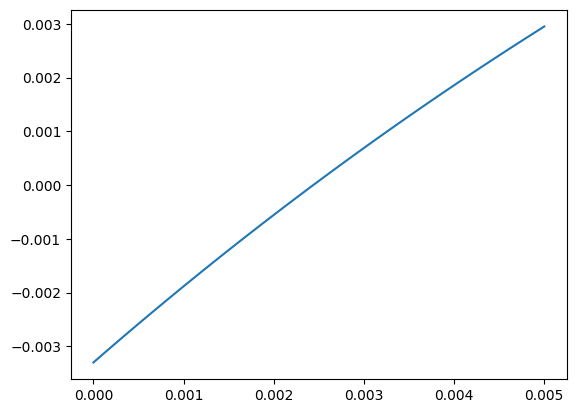

In [8]:
import matplotlib.pyplot as plt

sigmas_bf = np.linspace(0, 0.005, 100)
plt.plot(sigmas_bf, value_stgl(K_25P_STGL, K_25C_STGL, sigma_atm, sigma_rr, sigmas_bf, FXspot, df_eur_T, df_pln_T, T) - V_25STGL)

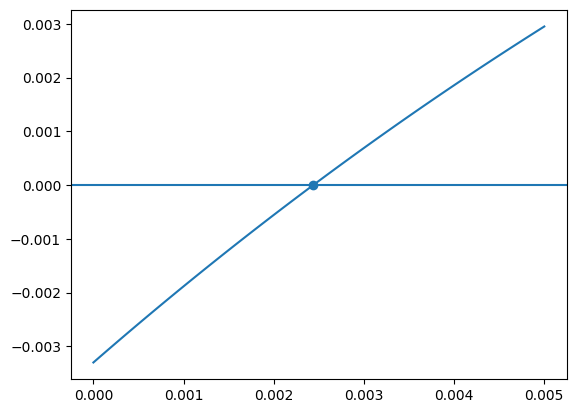

In [9]:
import scipy.optimize as optimize

def calculate_sigma_bf(K_25P_STGL, K_25C_STGL, sigma_atm, sigma_rr, FXspot, df_eur_T, df_pln_T, T, V_25STGL):
    def func(sigma_bf):
        return value_stgl(K_25P_STGL, K_25C_STGL, sigma_atm, sigma_rr, sigma_bf, FXspot, df_eur_T, df_pln_T, T) - V_25STGL
    sigma_bf = optimize.newton(func, 0.003)
    return sigma_bf
    
plt.scatter(calculate_sigma_bf(K_25P_STGL, K_25C_STGL, sigma_atm, sigma_rr, FXspot, df_eur_T, df_pln_T, T, V_25STGL), 0)
plt.plot(sigmas_bf, value_stgl(K_25P_STGL, K_25C_STGL, sigma_atm, sigma_rr, sigmas_bf, FXspot, df_eur_T, df_pln_T, T) - V_25STGL)
plt.axhline(y=0)

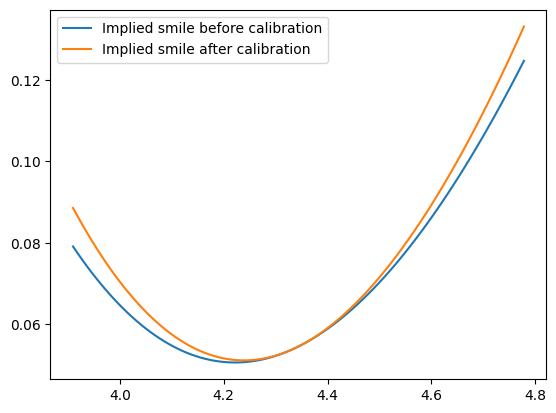

In [10]:
Ks = np.linspace(FXspot*0.9, FXspot*1.1, 100)
vols_before_calibration = interpolated_volatility_vv(Ks, sigma_atm, sigma_rr, sigma_bf, FXspot, df_eur_T, df_pln_T, T)

sigma_bf_calibrated = calculate_sigma_bf(K_25P_STGL, K_25C_STGL, sigma_atm, sigma_rr, FXspot, df_eur_T, df_pln_T, T, V_25STGL)
vols_after_calibration = interpolated_volatility_vv(Ks, sigma_atm, sigma_rr, sigma_bf_calibrated, FXspot, df_eur_T, df_pln_T, T)

plt.plot(Ks, vols_before_calibration, label='Implied smile before calibration')
plt.plot(Ks, vols_after_calibration, label='Implied smile after calibration')
plt.legend()

In [129]:
import holidays as h

import datetime
start = datetime.date(2023, 1, 1)
end = datetime.date(2024, 12, 31)

# Dodać dane z dni "specjalnych"
pl_fin_events = list(pd.read_excel('fin_events.xlsx', sheet_name='PL')['Date'])
eu_fin_events = list(pd.read_excel('fin_events.xlsx', sheet_name='EU')['Date'])

def get_number_of_days(start, end):

    dates = pd.date_range(start, end)
    num_days = 0
    prefix_sum_days = []
    
    for day in dates:
        year = day.year
        poland_holidays = h.Poland(year)
        euro_holidays = h.EuropeanCentralBank(year)
        is_poland_workday = float(not (day in poland_holidays.keys() or day.weekday() > 4)) * 0.5
        is_euro_workday = float(not (day in euro_holidays.keys() or day.weekday() > 4)) * 0.5
        num_days += is_poland_workday + is_euro_workday + 0.25 * float(day in pl_fin_events) + \
        0.25 * float(day in eu_fin_events)
        prefix_sum_days.append(num_days)

    return num_days, prefix_sum_days, dates

num_days, prefix_sum_days, dates = get_number_of_days(start, end)
weights_df = pd.DataFrame({'prefix_sum_days': prefix_sum_days, 'dates': dates})
num_days

533.5

In [130]:
def num_trading_days(date1, date2, weights_df):
    date1 = pd.to_datetime(date1 - datetime.timedelta(days=1))
    date2 = pd.to_datetime(date2 - datetime.timedelta(days=1))
    prefix_sum_days = list(weights_df[(weights_df['dates'] >= date1) & (weights_df['dates'] <= date2)]['prefix_sum_days'])
    return prefix_sum_days[-1] - prefix_sum_days[0]

start = datetime.date(2024, 4, 30)
end = datetime.date(2024, 5, 6)
num_trading_days(start, end, weights_df)

4.0

/var/folders/j8/hkm1dd710bdccwg_cxjfm8780000gn/T/ipykernel_83375/418951884.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  closest_before = days[idx - 1]
/var/folders/j8/hkm1dd710bdccwg_cxjfm8780000gn/T/ipykernel_83375/418951884.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  closest_after = days[idx]


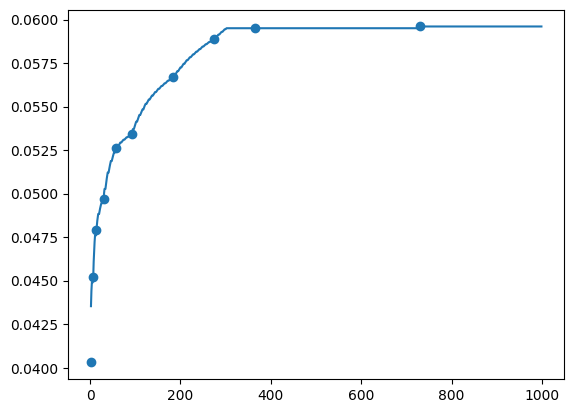

In [135]:
# Interpolacja zmienności po czasie, kolumna
def interpolate_sigma_along_time(t1, sigma1, t2, sigma2, t):
    if t <= t1:
        return sigma1
    elif t >= t2:
        return sigma2
    else:
        tau = (t - t1)/(t2 - t1)
        inter_vol = np.sqrt((sigma1**2 * t1 + tau * (sigma2**2 * t2 - sigma1**2 * t1))/t)
        return inter_vol

def find_t1_t2(t, days):
    # t = liczba dni do wygaszenia
    # days = dni do wygaszenia opcji
    idx = np.searchsorted(days, t, side='left')
    
    if idx > 0:
        closest_before = days[idx - 1]
    else:
        closest_before = None

    if idx < len(days):
        closest_after = days[idx]
    else:
        closest_after = None

    return closest_before, closest_after

def find_date1_date2(t1, t2, data):
    return data[data['Days'] == t1].iloc[0], data[data['Days'] == t2].iloc[0]

def interpolate_sigma(t, data, holidays, vol_type):
    # t is days to expiry
    # data = volatility data
    # holidays = holiday dates
    # vol_type = 'ATM', '10P', ...
    t1, t2 = find_t1_t2(t, data['Days'])
    data1, data2 = find_date1_date2(t1, t2, data)
    date = data1['Date'] + datetime.timedelta(days=int(t-t1))
    start_date = data.iloc[0]['Date'] - datetime.timedelta(days=int(data.iloc[0]['Days']))
    t1 = num_trading_days(start_date, data1['Date'], holidays)
    t2 = num_trading_days(start_date, data2['Date'], holidays)
    t = num_trading_days(start_date, date, holidays)
    
    return interpolate_sigma_along_time(t1, data1[vol_type], t2, data2[vol_type], t)
    


t = 46
vol_type = 'ATM'
volatlities = []
for t in range(2, 1000):
    volatlities.append(interpolate_sigma(t, smile, weights_df, vol_type))

plt.plot(list(range(2, 1000)), volatlities)
plt.scatter(x=smile['Days'].iloc[:10], y=smile['ATM'].iloc[:10])